In [1]:
import sys
import os
import time
from importlib import reload
import glob
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal,osr,ogr
from scipy.special import jv
sys.path.append(r"/mnt/c/Users/Nakata Kazuki/Documents/プログラム/2022/kn-general_analysis_tools/kn-general_analysis_tools/")
#sys.path.append(r"/mnt/d/プログラム/2022/kn-general_analysis_tools/")

from knool.satellite.algorithm import pmw_processor
from knool.fortlib import pmw_processor as fpmw
from knool.satellite.data import modis,amsr2
from knool.geophysics import thermal
import knool.geodata as gp
from knool.geodata import geo_search,geo_info
from knool import fortlib
reload(fortlib)
import xarray as xr
from datetime import datetime as dt
from datetime import timedelta
import work_path
import geopandas as gpd
import pandas as pd
import time as tm

/mnt/c/Users/Nakata Kazuki/Documents/プログラム/2022/kn-general_analysis_tools/kn-general_analysis_tools/knool/geophysics/params_physics_aoi.yaml


Warning 1: Failed to fetch spatial reference on layer output to build transformer, assuming matching coordinate systems.


(2240, 1520) (2, 2240, 1520)


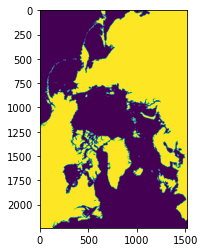

In [2]:
# メインプロセス
output_dir=r"/mnt/d/data/PROC/PROC_12KM"
range_x=20 #pixel
range_y=30 #pixel
fwhm_x=7000 #meter
fwhm_y=12000 #meter
#antenna_func=derive_points_bessel_beam
antenna_func=pmw_processor.get_antenna_pattern_gaussian_beam

dst_epsg=3413; dst_epsg_str="EPSG:3413"
lt_x=-3850*1000
lt_y=5850*1000
rb_x=3750*1000
rb_y=-5350*1000
source=osr.SpatialReference()
source.ImportFromEPSG(4326)
target=osr.SpatialReference()
target.ImportFromEPSG(dst_epsg) #3411:arctic, 3412:antarctic
res=5000#20000#6250
proj=geo_search.Grid(source,target,lt_x, lt_y, rb_x, rb_y, res,["time","tbv","tbh","sx","sy","sz"])
land_ds=proj.get_land_data()
latlon=gp.geo_info.get_latlons_from_raster(land_ds)
test=land_ds.ReadAsArray()
#plt.figure(figsize=(15,15))
plt.imshow(test)
print(test.shape,latlon.shape)

In [3]:
def processing(infile_list,proj):
    #-----------read data------------
    
    latmin=30
    latmax=90
    i=0
    for infile in infile_list:
        i=i+1
        knras2=amsr2.AMSR2_L1B(infile)
        knras2.set_lat_range(latmin,latmax) #-80 -45
        lata,lona=knras2.lat,knras2.lon
#         eaz=np.radians(knras2.get_earth_azimuth())
#         ein=np.radians(knras2.get_earth_incidence())
        time=knras2.get_obs_time()
#         scene_num=np.full(eaz.shape,float(i))
        tbv=knras2.get_brightness_temperature(8) #36
        tbh=knras2.get_brightness_temperature(7) #36
        sx,sy,sz=knras2.get_satellite_position()
        proj.stack(lata,lona, [time,tbv,tbh,sx,sy,sz])
    return proj

infile_list=glob.glob(r"/mnt/d/data/Develop/SIR/*")
indir=r"/mnt/d/data/Develop/SIR/GW1AM2_"
for iy in [2019]: #2013 2014 2015 2016 2017 2018 #2002 #2007 2008 2009 2010do 
    for im in [1]: #9 10 11 12 #4 5 9 10 11 12
        idate=(dt(iy,im+1,1)-dt(iy,im,1)).days
        for idd in [1]: #range(1,idate+1): 
            idate2=(dt(iy,im,idd)-dt(iy,1,1)).days+1
            print(iy,im,idd)
            date1=dt(iy,im,idd)
            date2m1=(date1-timedelta(days=1)).strftime("%Y%m%d")
            date2=date1.strftime("%Y%m%d")
            date2p1=(date1+timedelta(days=1)).strftime("%Y%m%d")
            
            print(date2m1,date2,date2p1)
            indirm1=indir + date2m1 + '*'
            indir=indir + date2 + '*'
            indirp1=indir + date2p1 + '*'

            infile_list_m1=sorted(glob.glob(indirm1))[-3:]
            infile_list=sorted(glob.glob(indir))
            infile_list_p1=sorted(glob.glob(indirp1))[:2]
            infile_list.extend(infile_list_m1)
            infile_list.extend(infile_list_p1)
            infile_list=sorted(infile_list)
            inum=len(infile_list)
            if inum!=0:
                print(inum)
                proj=processing(infile_list,proj)
                print('finish')

2019 1 1
20181231 20190101 20190102
32
finish


In [6]:
mask=np.full([proj.nx,proj.ny],0)
mask=land_ds.ReadAsArray()[::-1].T
mask=np.where(mask==1,999,0)

print(mask.shape)
day=1; month=1; year=2019
grid_x=(proj.df["grid_x"].values+0.5).astype(np.float32)
grid_y=(proj.df["grid_y"].values+0.5).astype(np.float32)
# eaz=proj.df["eaz"].values.astype(np.float32)
# ein=proj.df["ein"].values.astype(np.float32)
tbv=proj.df["tbh"].values.astype(np.float32)
time=proj.df["time"].values.astype(np.float32)
# scene_num=proj.df["scene_num"].values
lat=proj.df["lat"].values.astype(np.float32)
lon=proj.df["lon"].values.astype(np.float32)

sx=proj.df["sx"].values#.astype(np.float64)
sy=proj.df["sy"].values#.astype(np.float64)
sz=proj.df["sz"].values#.astype(np.float64)

(1520, 2240)


In [ ]:


if month==1:
    maxday=(dt(year-1,12,31)-dt(year-1,1,1)).days +1 
    time=np.where(time>300,time-maxday,time)
    
#-------------get antenna pattern--------
antenna_func=pmw_processor.get_antenna_pattern_gaussian_beam
#antenna_func=kpmw.get_antenna_pattern_bessel_beam
int_ap=0.01
az=np.arange(-4,4+int_ap,int_ap)
el=np.arange(-5,5+int_ap,int_ap)
X, Y = np.meshgrid(az, el)
func_args=[0.35,0.35,X,Y]
ap=pmw_processor.antenna_pattern_integration(2.6,0.1,antenna_func, func_args)

# func_args=[0.6*10/12,0.35*10/12,X,Y]
# ap=antenna_func(*func_args)
# print(ap.shape)
#plt.imshow(ap)

#-----------prepare coord_transform object for NSIDC polar stereographic-----------
source=osr.SpatialReference()
source.ImportFromEPSG(4326)
target=osr.SpatialReference()
target.ImportFromEPSG(3411) #3411:arctic, 3412:antarctic
coord_transform = osr.CoordinateTransformation(source, target)
coord_transform_inv = osr.CoordinateTransformation(target, source)

#---------2D to 1D for azimuth and incidence angles, and lat lon array-----------
# srange = geo_info.calc_slant_range1(lat, ein, np.pi*47.5/180, 699600)
# sx=srange*np.sin(eaz)*np.sin(ein)
# sy=srange*np.cos(eaz)*np.sin(ein)
# sz=srange*np.cos(ein)
vb = np.array(geo_info.transform_lla_to_ecef(lat, lon, 0)).T #point vector at the earth surface
vs=np.array([sx.reshape(-1),sy.reshape(-1),sz.reshape(-1)]).T
h=mask.shape[0]
w=mask.shape[1]
vg = np.array(geo_info.transform_lla_to_ecef(latlon[0].T[:,::-1].reshape(-1),latlon[1].T[:,::-1].reshape(-1), 0)).reshape(3,h,w).transpose(1,2,0)

ft=tm.time()
proc=fortlib.pmw_processor.rsir
test,test2=proc(grid_x,grid_y,vs,vb,vg,time,tbv,mask,latlon[1].T[:,::-1],latlon[0].T[:,::-1],
                day=int(1),ltod_min=float(0.25),ltod_max=float(0.75),rot_offset=float(0),
                wsize=int(11),ap=ap.T,int_ap=float(int_ap),res=float(5000),fwhm=float(10000))
# proc=fortlib.pmw_processor.l1b_to_l3_wa
# test,test2=proc(grid_x,grid_y,time,tbv,mask,latlon[1].T[:,::-1],latlon[0].T[:,::-1],
#                 day=int(1),ltod_min=float(0.25),ltod_max=float(0.75),rot_offset=float(0),
#                 wsize=int(11),fwhm=float(10000),res=float(5000))
print(tm.time()-ft)


(6, 0)


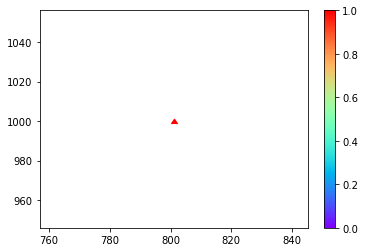

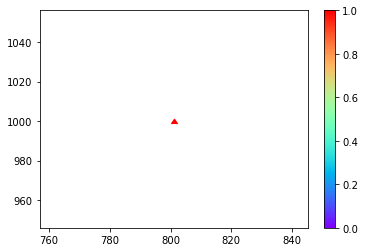

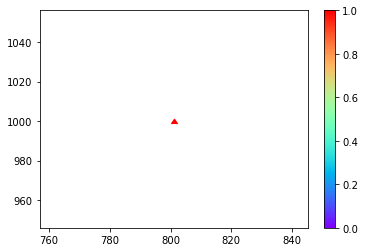

(1001, 801) (1001, 801) (1001, 801)


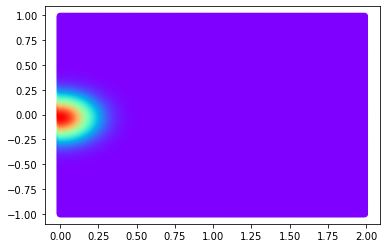

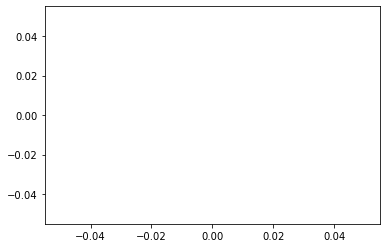

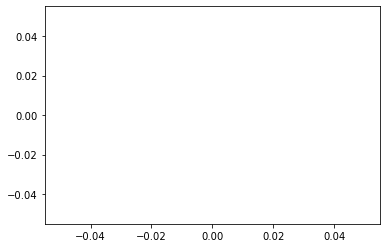

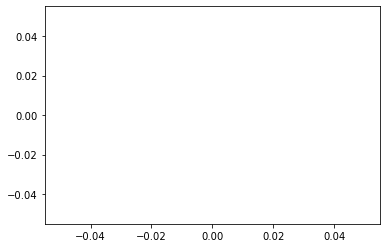

In [6]:
ii=801
jj=1001
t5=test4[test4[:,0]>0].T
print(t5.shape)
plt.scatter(ii,jj,marker=6,c="red")
plt.scatter(t5[0],t5[1],c=t5[2],cmap="rainbow")
plt.colorbar()
plt.show()
plt.scatter(ii,jj,marker=6,c="red")
plt.scatter(t5[0],t5[1],c=t5[3],cmap="rainbow",vmin=0,vmax=1)
plt.colorbar()
plt.show()

tan1=np.tan(np.radians(t5[4]))
tan2=np.tan(np.radians(t5[5]))
theta=np.degrees(np.arctan(np.sqrt(tan1**2+tan2**2)))
plt.scatter(ii,jj,marker=6,c="red")
plt.scatter(t5[0],t5[1],c=theta,cmap="rainbow")
plt.colorbar()
plt.show()
print(X.shape,Y.shape,ap.shape)
plt.scatter(X[400:600,400:600].reshape(-1),Y[400:600,400:600].reshape(-1),c=ap[400:600,400:600].reshape(-1),cmap="rainbow")
plt.show()
# plt.scatter(ii,jj,marker=6,c="red")
# plt.scatter(t5[0],t5[1],c=t5[4],cmap="bwr")
# plt.show()
# plt.scatter(ii,jj,marker=6,c="red")
# plt.scatter(t5[0],t5[1],c=t5[5],cmap="bwr")
# plt.show()


plt.plot(t5[2].reshape(-1))
plt.plot(t5[3].reshape(-1))
plt.show()
plt.plot(theta.reshape(-1))
plt.show()
plt.scatter(theta.reshape(-1),t5[3].reshape(-1))
# plt.scatter(theta.reshape(-1),t5[2].reshape(-1))

float32 float32
(2, 2240, 1520)
Exported


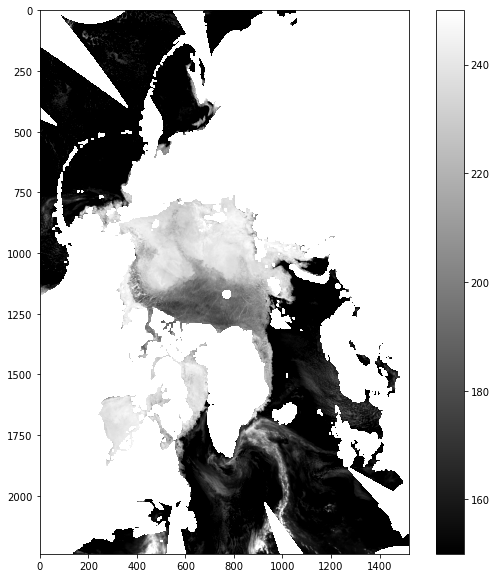

In [7]:
print(grid_x.dtype,tbv.dtype)
plt.figure(figsize=(10,10))
#plt.imshow(test2.T[::-1,:],vmin=0,vmax=30.0)#,cmap="gray",vmin=150,vmax=250)
plt.imshow(test.T[::-1,:],cmap="gray",vmin=150,vmax=250)

#plt.imshow(latlon[1])
plt.colorbar()
test3=np.array([test.T[::-1],test2.T[::-1]])
print(test3.shape)
proj.output=test3
proj.export_output("tes14.tif")


In [8]:
infile=r"/mnt/d/data/Develop/SIR/GW1AM2_201812310033_187D_L1SGBTBR_2220220.h5"
knras2=amsr2.AMSR2_L1B(infile)
knras2.keys()

{'Attitude_Data': 0, 'Brightness_Temperature_(10.7GHz,H)': 1, 'Brightness_Temperature_(10.7GHz,V)': 2, 'Brightness_Temperature_(18.7GHz,H)': 3, 'Brightness_Temperature_(18.7GHz,V)': 4, 'Brightness_Temperature_(23.8GHz,H)': 5, 'Brightness_Temperature_(23.8GHz,V)': 6, 'Brightness_Temperature_(36.5GHz,H)': 7, 'Brightness_Temperature_(36.5GHz,V)': 8, 'Brightness_Temperature_(6.9GHz,H)': 9, 'Brightness_Temperature_(6.9GHz,V)': 10, 'Brightness_Temperature_(7.3GHz,H)': 11, 'Brightness_Temperature_(7.3GHz,V)': 12, 'Brightness_Temperature_(89.0GHz-A,H)': 13, 'Brightness_Temperature_(89.0GHz-A,V)': 14, 'Brightness_Temperature_(89.0GHz-B,H)': 15, 'Brightness_Temperature_(89.0GHz-B,V)': 16, 'Cold_Sky_Mirror_Count_6_to_36': 17, 'Cold_Sky_Mirror_Count_89': 18, 'Earth_Azimuth': 19, 'Earth_Incidence': 20, 'Hot_Load_Count_6_to_36': 21, 'Hot_Load_Count_89': 22, 'Interpolation_Flag_6_to_36': 23, 'Interpolation_Flag_89': 24, 'Land_Ocean_Flag_6_to_36': 25, 'Land_Ocean_Flag_89': 26, 'Latitude_of_Observation

In [9]:
mask=np.full([proj.nx,proj.ny],0)
mask=land_ds.ReadAsArray()[::-1].T
mask=np.where(mask==1,999,0)


#-------------get antenna pattern--------
antenna_func=pmw_processor.get_antenna_pattern_gaussian_beam
#antenna_func=kpmw.get_antenna_pattern_bessel_beam
int_ap=0.01
az=np.arange(-4,4+int_ap,int_ap)
el=np.arange(-5,5+int_ap,int_ap)
X, Y = np.meshgrid(az, el)
func_args=[0.35,0.35,X,Y]
ap=pmw_processor.antenna_pattern_integration(2.6,0.1,antenna_func, func_args)
#ap=pmw_processor.antenna_pattern_integration(1.3,0.1,antenna_func, func_args)
# func_args=[0.6*10/12,0.35*10/12,X,Y]
# ap=antenna_func(*func_args)

#print(ap.shape)
#plt.imshow(ap)

grid_x=(proj.df["grid_x"].values+0.5).astype(np.float32)
grid_y=(proj.df["grid_y"].values+0.5).astype(np.float32)
eaz=proj.df["eaz"].values.astype(np.float32)
ein=proj.df["ein"].values.astype(np.float32)
tbv=proj.df["tbh"].values.astype(np.float32)
time=proj.df["time"].values.astype(np.float32)
# scene_num=proj.df["scene_num"].values
lat=proj.df["lat"].values.astype(np.float32)
lon=proj.df["lon"].values.astype(np.float32)
sx=proj.df["sx"].values#.astype(np.float64)
sy=proj.df["sy"].values#.astype(np.float64)
sz=proj.df["sz"].values#.astype(np.float64)



(11, 3)
hi [[ 369541.88308066 -142505.7029499  6344484.30111989]] [0.63800722]
hi [[ 359105.80245634 -143923.94201755 6345047.74302669]] [0.63967162]
hi [[ 365332.23061911 -145864.97662062 6344650.63429054]] [0.79450467]
hi [[ 366303.08930578 -138154.17644013 6344766.46268066]] [0.70817095]
hi [[ 358854.43059638 -141756.63309007 6345110.33326455]] [0.62519014]
hi [[ 363470.59172738 -139967.37970446 6344888.79298207]] [0.95128545]
hi [[ 367574.38948219 -142703.87205841 6344593.40451954]] [0.7971524]
hi [[ 360733.66933833 -139312.57844274 6345058.25552019]] [0.72339131]
hi [[ 366789.12461479 -145317.0599935  6344579.62861311]] [0.72077593]
hi [[ 363442.600422   -140836.48267034 6344871.28258905]] [0.96407226]
--------------------------------------------------------------
 image nx=        1520 ,ny=        2240
 antenna pattern nx=         801 ,ny=        1001


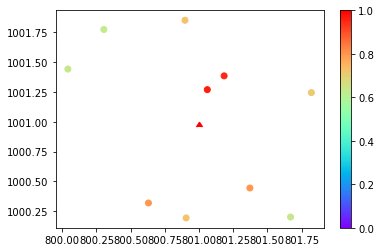

In [10]:
srange = geo_info.calc_slant_range1(lat, ein, np.pi*47.5/180, 699600)
sx=srange*np.sin(eaz)*np.sin(ein)
sy=srange*np.cos(eaz)*np.sin(ein)
sz=srange*np.cos(ein)
vb = np.array(geo_info.transform_lla_to_ecef(lat, lon, 0)).T #point vector at the earth surface
vs = np.array(geo_info.transform_enu_to_ecef(vb[:,0], vb[:,1], vb[:,2], lat, lon, 0, sx,sy,sz)).T#s/c position vector
h=mask.shape[0]
w=mask.shape[1]
vg = np.array(geo_info.transform_lla_to_ecef(latlon[0].T[:,::-1].reshape(-1),latlon[1].T[:,::-1].reshape(-1), 0)).reshape(3,h,w).transpose(1,2,0)

# print(vb)
# print(vs)
# print(vg)
# print(vg.shape)
ig=801
jg=1001
ti=1
xmin=1
xmax=42

vg2=vg[ig-1,jg-1].reshape([1,3])
vb2=vb[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)][xmin:xmax]
vs2=vs[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)][xmin:xmax]
gx2=grid_x[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)][xmin:xmax]
gy2=grid_y[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)][xmin:xmax]
tbv2=tbv[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)][xmin:xmax]
time2=time[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)][xmin:xmax]

print(vb[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)].shape)
i,j,k=fpmw.calc_boresight_basis_vectors(vb2,vs2)
# print(vb2.shape)
# print(vb2)
# print(vs2)
# print(i)#,j,k)
ap2=[]
az2=[]
el2=[]

for ii in range(vb2.shape[0]):
    b=vb2[ii]-vs2[ii]
    vb22=np.array([vb2[ii]])
    vs22=np.array([vs2[ii]])
    i,j,k=fpmw.calc_boresight_basis_vectors(vb22,vs22)
    az,el=fpmw.calc_local_az_el_angle(i[0],j[0],k[0],b,vb22,vg2)
#     az2.append(az*180/np.pi)
#     el2.append(el*180/np.pi)
#    print(az*180/np.pi)
    az2=np.int32(np.round(az*180/np.pi/int_ap))
    el2=np.int32(np.round(el*180/np.pi/int_ap))
    ap2.append(ap[el2+500,az2+400])
#    print(i,j,k,b,vb22,vg2,az,el,ap[el2+500,az2+400])
    print("hi",vb22,ap[el2+500,az2+400])

print("--------------------------------------------------------------")
proc=fortlib.pmw_processor.rsir
ii=801
jj=1001
test4,test,test2=proc(gx2,gy2,vs2,vb2,vg,time2,tbv2,mask,latlon[1].T[:,::-1],latlon[0].T[:,::-1],
                day=int(1),ltod_min=float(0.25),ltod_max=float(0.75),rot_offset=float(0),
                wsize=int(11),ap=ap.T,int_ap=float(int_ap),i_t=int(ii),j_t=int(jj))

plt.scatter(ig,jg,marker=6,c="red")
plt.scatter(gx2,gy2,c=ap2,cmap="rainbow",vmin=0,vmax=1)
plt.colorbar()
plt.show()


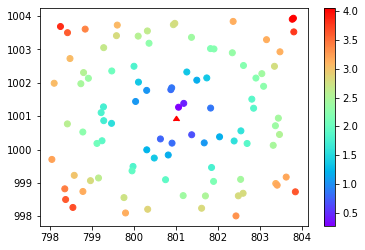

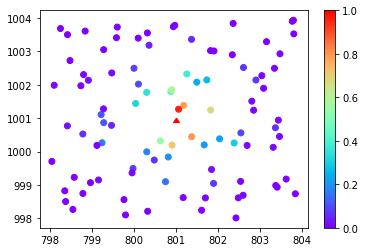

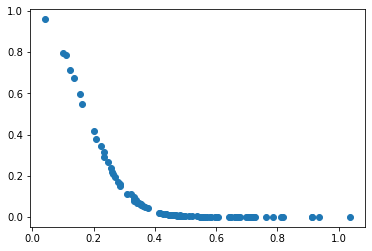

In [11]:
#-------------get antenna pattern--------
antenna_func=pmw_processor.get_antenna_pattern_gaussian_beam
#antenna_func=kpmw.get_antenna_pattern_bessel_beam
int_ap=0.01
az=np.arange(-4,4+int_ap,int_ap)
el=np.arange(-5,5+int_ap,int_ap)
X, Y = np.meshgrid(az, el)
func_args=[0.35,0.35,X,Y]
ap=pmw_processor.antenna_pattern_integration(2.6,0.1,antenna_func, func_args)
#ap=pmw_processor.antenna_pattern_integration(1.3,0.1,antenna_func, func_args)
# func_args=[0.6*10/12,0.35*10/12,X,Y]
# ap=antenna_func(*func_args)

#print(ap.shape)
#plt.imshow(ap)

grid_x=(proj.df["grid_x"].values+0.5).astype(np.float32)
grid_y=(proj.df["grid_y"].values+0.5).astype(np.float32)
eaz=proj.df["eaz"].values.astype(np.float32)
ein=proj.df["ein"].values.astype(np.float32)
tbv=proj.df["tbh"].values.astype(np.float32)
time=proj.df["time"].values.astype(np.float32)
# scene_num=proj.df["scene_num"].values
lat=proj.df["lat"].values.astype(np.float32)
lon=proj.df["lon"].values.astype(np.float32)
sx=proj.df["sx"].values#.astype(np.float64)
sy=proj.df["sy"].values#.astype(np.float64)
sz=proj.df["sz"].values#.astype(np.float64)

# srange = geo_info.calc_slant_range1(lat, ein, np.pi*47.5/180, 699600)
# sx=srange*np.sin(eaz)*np.sin(ein)
# sy=srange*np.cos(eaz)*np.sin(ein)
# sz=srange*np.cos(ein)
vb = np.array(geo_info.transform_lla_to_ecef(lat, lon, 0)).T #point vector at the earth surface
# vs = np.array(geo_info.transform_enu_to_ecef(vb[:,0], vb[:,1], vb[:,2], lat, lon, 0, sx,sy,sz)).T#s/c position vector
h=mask.shape[0]
w=mask.shape[1]
vg = np.array(geo_info.transform_lla_to_ecef(latlon[0].T[:,::-1].reshape(-1),latlon[1].T[:,::-1].reshape(-1), 0)).reshape(3,h,w).transpose(1,2,0)
vs=np.array([sx.reshape(-1),sy.reshape(-1),sz.reshape(-1)]).T

# print(vb)
# print(vs)
# print(vg)
# print(vg.shape)
ig=801
jg=1001
ti=3
vg2=vg[ig-1,jg-1].reshape([1,3])
vb2=vb[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)]
vs2=vs[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)]
gx2=grid_x[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)]
gy2=grid_y[(np.abs(grid_x-ig)<ti)&(np.abs(grid_y-jg)<ti)]

ap2=[]
az2=[]
el2=[]
for ii in range(vb2.shape[0]):
    b=vb2[ii]-vs2[ii]
    vb22=np.array([vb2[ii]])
    vs22=np.array([vs2[ii]])
    i,j,k=fpmw.calc_boresight_basis_vectors(vb22,vs22)
    az,el=fpmw.calc_local_az_el_angle(i[0],j[0],k[0],b,vb22,vg2)
    az2.append(az*180/np.pi)
    el2.append(el*180/np.pi)
#    print(az*180/np.pi)
    az=np.int32(np.round(az*180/np.pi/int_ap))
    el=np.int32(np.round(el*180/np.pi/int_ap))
    ap2.append(ap[el+500,az+400])
    

az3=np.array(az2)
el3=np.array(el2)
testest2=np.sqrt((gx2-ig)**2+(gy2-jg)**2)
plt.scatter(ig,jg,marker=6,c="red")
plt.scatter(gx2,gy2,c=testest2,cmap="rainbow")
plt.colorbar()
plt.show()
plt.scatter(ig,jg,marker=6,c="red")
plt.scatter(gx2,gy2,c=ap2,cmap="rainbow",vmin=0,vmax=1)
plt.colorbar()
plt.show()

tan1=np.tan(np.radians(az2))
tan2=np.tan(np.radians(el2))
theta=np.degrees(np.arctan(np.sqrt(tan1**2+tan2**2)))
plt.scatter(theta,ap2)
plt.show()



(200, 200)


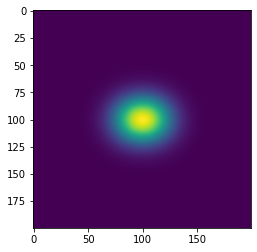

In [12]:
antenna_func=pmw_processor.get_antenna_pattern_gaussian_beam
#antenna_func=kpmw.get_antenna_pattern_bessel_beam
int_ap=0.01
az=np.arange(-1,1,int_ap)
el=np.arange(-1,1,int_ap)
X, Y = np.meshgrid(az, el)
func_args=[0.35,0.35,X,Y]
ap=pmw_processor.antenna_pattern_integration(1.3,0.1,antenna_func, func_args)
print(ap.shape)
plt.imshow(ap)

In [13]:
tes1=np.radians([80])
tes2=np.radians([80])

print(np.degrees(np.sqrt(tes1**2+tes2**2)))

tan1=np.tan(tes1)
tan2=np.tan(tes2)
print(np.degrees(np.arctan(np.sqrt(tan1**2+tan2**2))))

[113.13708499]
[82.89292389]
